# Discrete areas

Split area into discrete regions.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
from h3 import h3

from pylab import rcParams
rcParams['figure.figsize'] = (10, 7)

import pandas as pd
pd.set_option('max_columns', 40)
pd.set_option('max_rows', 20)
pd.set_option('precision', 3)

## Prepare data

In [2]:
%%time 

data = pd.read_feather('structured_data.feather')

data = data.sample(100000)

data.head()

## Points to h3 indexes

In [3]:
def point_h3_indexes(points: pd.DataFrame, res: int) -> np.ndarray:
    h3_indexes = points.apply(
        lambda point: h3.geo_to_h3(point['lat'], point['lon'], res),
        axis=1
    )
    return h3_indexes
    
resolution = 8
h3_indexes_res_8 = point_h3_indexes(data, resolution)

resolution = 9
h3_indexes_res_9 = point_h3_indexes(data, resolution)

## Choropleth map

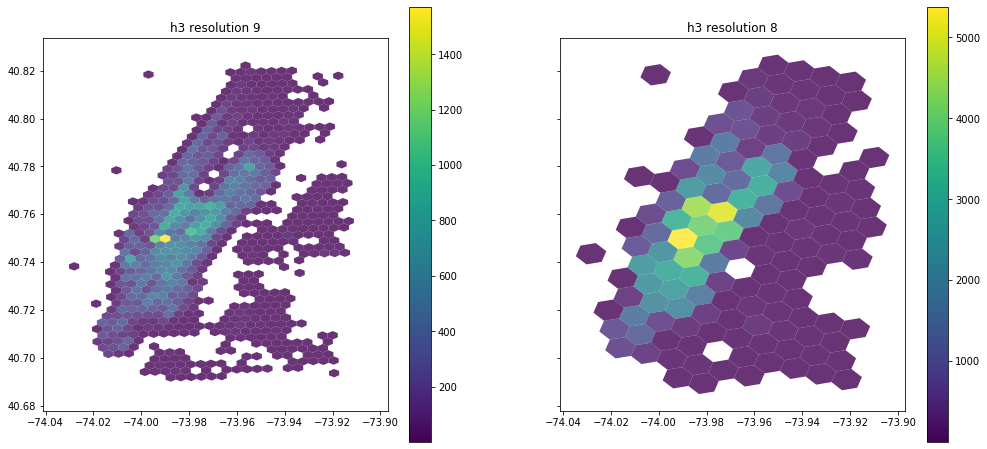

In [4]:
from shapely.geometry import Polygon
import geopandas as gpd


def h3_to_polygon(item):
    h3_index = item['index']
    boundary = h3.h3_to_geo_boundary(h3_address=h3_index, geo_json=True)
    return Polygon(boundary)


fig = plt.figure(figsize=(17, 8))
(ax1, ax2) = fig.subplots(1, 2, sharex=True, sharey=True)

counts = h3_indexes_res_9.value_counts()
counts = counts.to_frame(name='counts').reset_index()
geo_df = gpd.GeoDataFrame(counts, geometry=counts.apply(h3_to_polygon, axis=1))
geo_df.plot(column='counts', alpha=0.8, legend=True, ax=ax1)
ax1.set_title('h3 resolution 9')

counts = h3_indexes_res_8.value_counts()
counts = counts.to_frame(name='counts').reset_index()
geo_df = gpd.GeoDataFrame(counts, geometry=counts.apply(h3_to_polygon, axis=1))
geo_df.plot(column='counts', alpha=0.8, legend=True, ax=ax2)
ax2.set_title('h3 resolution 8');

## Interactive map

Create an interactive map with unique hexagons

In [5]:
import geojson
from geojson import FeatureCollection
import folium

def indexes_to_polygons(h3_indexes):
    polygons = []
    
    for h in h3_indexes:
        polygon = Polygon(h3.h3_to_geo_boundary(h3_address=h, geo_json=True))
        polygons.append(polygon)
        
    feature_collection = FeatureCollection(polygons)
    return geojson.dumps(feature_collection)
        
def create_style_fn(color, opacity=0.1, weight=2):
    """Ugly way to set color of json features"""
    
    return lambda feature: {
        'fillColor': None,
        'color': color,
        'weight': weight,
        'fillOpacity': opacity
    }

m = folium.Map(location=[40.7536, -73.9811], zoom_start=12)

# resolution 8
feature_collection = indexes_to_polygons(h3_indexes_res_8.unique())
folium.GeoJson(
    feature_collection, 
    style_function=create_style_fn('blue', opacity=0.1, weight=2), 
    ).add_to(m)

# resolution 9
feature_collection = indexes_to_polygons(h3_indexes_res_9.unique())
folium.GeoJson(
    feature_collection, 
    style_function=create_style_fn('green', opacity=0., weight=1)
    ).add_to(m)

m

## Points per area

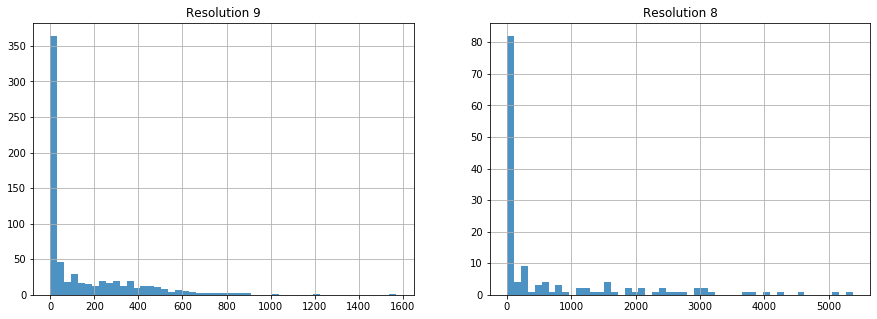

In [6]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.title('Resolution 9')
h3_indexes_res_9.value_counts().hist(bins=50, alpha=0.8);

plt.subplot(122)
plt.title('Resolution 8')
h3_indexes_res_8.value_counts().hist(bins=50, alpha=0.8);